# Lidar data × Python Tutorial Session 1. ～点群データことはじめ～

## はじめに
---
Lidar（Light Detection and Ranging, Laser Imaging Detection and Ranging）とは、レーザー（光）を用いて、対象までの距離や性質を分析するものです。Lidarで取得したデータには "x", "y", "z" 座標の他に "反射強度" などが含まれており、ドローンや航空機などで取得した3次元点群データは、詳細な地形や地物の把握などに使用されており、目にする機会が増えて来た様に思います

チュートリアルではPythonを使用して、点群データ処理について学んでいきます。第一回のこのセッションでは、Lidar計測データフォーマットの1つである`.las`を題材に、実際のPythonコードを実行しながら学んでいきましょう。

 - 点群データ処理の為のライブラリー

 - 外部ライブラリのインストールと今回使用するライブラリのインポート

 - データの読み込みとメタデータの確認

 - 計測範囲の可視化と確認

 - 空間参照系の設定

 - データを眺める

<br><br><br><br>

 ## 点群データ処理の為のライブラリー
 ---
今回、点群データを処理するライブラリーとして、`PDAL（Point Data Abstraction Library）`を使用します。PDALはCLIで操作する方が一般的かもしれませんが、今回はPython APIを使用して、Notebook内で完結させます。

PDALは、点群データを変換および操作する為のC++のライブラリーです。PDALは様々なフォーマットのデータを読み書きする事が可能であり、ラスターデータとして出力する事もできます。

PDALは処理の流れを"Pipeline"として記述する事で、'読み込み' -> 'データ処理' -> '書き込み'というワークフローを作成し実行します。

今回はPython APIを使用するので、"GoogleColab"の環境内に"Anaconda"をインストールし、その中にPDALをインストールします。

<br><br><br><br>

## 外部ライブラリのインストールと今回使用するライブラリのインポート
---
GoogleColabでは直接データをアップロードする事も可能ですが、処理時間が掛かります。今回は事前に自分のGoogleDriveに使用する`.las`ファイルを保存しておき、そこから読み込んで使用しましょう。


In [ ]:
# 最初にこのセルを実行すると、一度セッションが再起動される。再起動されたら、次のセルを実行してもよい。
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [ ]:
# 今回のチュートリアルに必要なライブラリをインストールする。
# これも実行すると再起動がかかるかもしれないが、その後下のセルを実行する事が出来る。
!conda update -y -n base -c defaluts conda
!conda install --channel conda-forge pdal
!pip install PDAL open3d polars japanize_matplotlib folium mapclassify pyproj

In [ ]:
import json
import os
from pprint import pprint

import geopandas as gpd
from google.colab import drive
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pdal
import pyproj
import shapely
from shapely.plotting import plot_polygon

# GoogleDriveをマウント
drive.mount('/content/drive')

Mounted at /content/drive


<br><br><br><br>

## データの読み込みとメタデータの確認
---
"Pipeline"は辞書型のオブジェクト内に処理を記述して文字列に変換し使用します。
































In [ ]:
# GoogleDrive内にある`.las`ファイルまでのパス
INPUT_FILE = r'/content/drive/MyDrive/notebooks/LearnLidar_JFF/Izu.las'

In [ ]:
# Pipeline処理をDict型のオブジェクトに記述する。
sentence = {
    'pipeline': [
        { # データを読み込む処理
            'type' : 'readers.las', # <- .の後はフォーマットを指定、今回は`las`
            'filename': INPUT_FILE # <- GoogleDrive内にある`.las`ファイルまでのパス
        }
    ]
}

# Dict型のオブジェクトをJSON文字列に変換
json_sentence = json.dumps(sentence)


# PipelineのクラスにJSON文字列を渡し、インスタンスを作成する。
pipeline = pdal.Pipeline(json_sentence)
# Pipeline処理の実行
pipeline.execute()


# `.las`に入力されているメタデータの取得と表示
meta_data = pipeline.metadata
pprint(meta_data)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': '',
                              'compressed': False,
                              'copc': False,
                              'count': 22350278,
                              'creation_doy': 0,
                              'creation_year': 2023,
                              'dataformat_id': 3,
                              'dataoffset': 227,
                              'filesource_id': 0,
                              'global_encoding': 0,
                              'global_encoding_base64': 'AAA=',
                              'header_size': 227,
                              'major_version': 1,
                              'maxx': -124310,
                              'maxy': 33250,
                              'maxz': 681.46,
                              'minor_version': 2,
                              'minx': -124530,
                              'miny': 33100,
              

上記で出力したメタデータの **'spatialreference'** に注目します。

In [ ]:
srs = \
    meta_data\
        .get('metadata')\
        .get('readers.las')\
        .get('spatialreference')

print(f'SRS: {srs}')

SRS: 


**'spatialreference'** には何も記録されていません。**`Spatial Reference System（SRS: 空間参照系）`**とは、現実世界の位置を特定する為のルールであり、空間参照系の種類によって、原点となる場所が異なります。GISでは'SRS'と表記している場合と'CRS（Coordinate Reference System: 座標参照系）'と表記されている場合があります。


詳しく説明すると長くなるので、簡単に説明すると、大きく2つのグループに分ける事が出来ます。
 1. <b>地理座標系 ... </b>

    地理座標系の原点は地球の重心にあり、その重心からの角度で座標を表現するものです。通常よく目にする経緯度(経度: 140.23567, 緯度: 39.00345)などがこれにあたり、地球上のどこにいても座標を特定する事が可能な、非常に広域な座標系です。
    しかしデメリットとして距離や面積を正確に求めるのが難しくなります。

    有名な地理座標系には、GPSに使用されている<b>`WGS84(World Geodetic System 1984 : 世界測地系1984)`</b>があります。


 2. <b>投影座標系 ... </b>

    投影座標系の原点は様々な場所にあり、データの範囲などによってその原点を選択する事が出来ます。これは原点からの距離で座標を表現し、距離や面積を正確に求める事が出来ます。地球は平面ではありませんので、目的地に近い原点を持つ投影座標系を選択する事で、より正確な距離や面積を求める事が出来ます。

    都道府県を跨ぐような大きな範囲のデータセットであれば`UTM座標系`を選択しますが、今回のデータは静岡県内の局所的な範囲なので、そこに原点が近い<b>`JGD2011 Ⅷ（EPSG:6676）`</b>が、このデータの空間参照系かもしれません。

<br><br><br><br>

## 計測範囲の可視化と確認
---
空間参照系を設定する前に、本当にそのまま設定しても良いのか確認してみましょう。

メタデータを見ると、データ範囲の座標が書き込まれています。この情報を取り出して、`Polygon`のオブジェクトを作成し、動的なMapに投影して確認してみましょう。

In [ ]:
# metadata内から座標の最小値と最大値を取得
meta_data_readers = meta_data.get('metadata').get('readers.las')
x_min = meta_data_readers.get('minx')
x_max = meta_data_readers.get('maxx')
y_min = meta_data_readers.get('miny')
y_max = meta_data_readers.get('maxy')

# データの範囲を示す、shapely.Polygonのオブジェクトを作成
box = shapely.box(x_min, y_min, x_max, y_max)


count = meta_data_readers.get('count')
report = \
f"""
計測範囲面積   : {box.area / 10_000}ha
計測点数       : {'{0:,}'.format(count)}
1㎡あたりの点数: {round(count / box.area, 1)}
"""
print(report)


計測範囲面積   : 3.3ha
計測点数       : 22,350,278
1㎡あたりの点数: 677.3 



150

設定するSRSの確認。

下に出力したデータを見ると、**"Shizuoka-ken"** と書いてあります。
















In [ ]:
IN_SRS = 'EPSG:6676'
proj_crs = pyproj.CRS(IN_SRS)

# 今回は記事で見やすい様に"pretty=True"としていますが、普通は不要です。
IN_SRS = proj_crs.to_wkt()
pprint(IN_SRS)

('PROJCRS["JGD2011 / Japan Plane Rectangular CS '
 'VIII",BASEGEOGCRS["JGD2011",DATUM["Japanese Geodetic Datum '
 '2011",ELLIPSOID["GRS '
 '1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",6668]],CONVERSION["Japan '
 'Plane Rectangular CS zone VIII",METHOD["Transverse '
 'Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural '
 'origin",36,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude '
 'of natural '
 'origin",138.5,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale '
 'factor at natural '
 'origin",0.9999,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False '
 'easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False '
 'northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["northing '
 '(X)",north,ORDER[1],LENGTHUNIT["metre",1]],AXIS["easting '
 '(Y)",east,ORDER[2],LENGTHUNIT["metre",1]],USAGE[SCOPE["Cadastre, engineering '

In [ ]:
# geopandas.GeoDataFrameに格納し、OpenStreetMapに重ねて見る。
# 読み込みに少し時間がかかりますが、動的なMapを見る事が出来ます。
gdf = gpd.GeoDataFrame(geometry=[box], crs=IN_SRS)
gdf.explore()

Mapで確認するとわかる様に、岐阜県の山中に投影されてしまいました。

平面直角座標系は少しややこしいですが、多くの人がイメージする数学のXY座標（横軸がX、縦軸がY）と異なり、横軸がYで縦軸がXとなります。
国交省のWebサイトには以下の様に書かれています。

```
座標系のX軸は、座標系原点において子午線に一致する軸とし、真北に向う値を正とし、座標系のY軸は、座標系原点において座標系のX軸に直交する軸とし、真東に向う値を正とする。
```

つまり北方向は+Y、南方向は-Y、東方向は+X、西方向は-Yとなります。

この`.las`も上記の様にXYが逆になっていたのかもしれません。入れ替えてもう一度動的なMapに投影させてみましょう。


[平面直角座標系（平成14年国土交通省告示第九号）](https://www.gsi.go.jp/LAW/heimencho.html)



















In [ ]:
# XとYの位置を入れ替えてPolygonのオブジェクトを作成する。
# 前回:        shapely.box(x_min, y_min, x_max, y_max)
reversed_box = shapely.box(y_min, x_min, y_max, x_max)
reversed_gdf = gpd.GeoDataFrame(geometry=[reversed_box], crs=IN_SRS)
reversed_gdf.explore()

今度は間違いなく、伊豆の山中に投影する事ができました。

このデータを取得した場所の概要は知りませんが、恐らく**空間参照系は`JGD2011 Ⅷ（EPSG:6676）`**であり、**データのXYが逆になっている**という事がわかりました。
<br><br><br><br>


## 空間参照系の設定
---
ここまでで空間参照系とデータのXY座標が逆になっている事がわかりました。平面直角座標系ではXYが数学座標と逆である事は正しいのですが、GISなどでデータを扱う場合は、数学座標の考え方とそろえた方が扱いやすいでしょう。

次はこのデータに空間参照系を定義し、XY座標の入力されている列を入れ替えて保存してしまいます。この処理は、データを読み込み、メタデータを確認した時と同じように、"Pipeline" で行う事が出来ます。

XとYの列を入れ替える為に、これらが「何列目に入力されているか」を知る必要があります。

上のセルで既に読み込んでいるデータからDataFrameを作成し、実際に入力されている要素を見てみましょう。















In [ ]:
pipeline.get_dataframe(0).head(3)

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,-124484.26,33100.84,637.23,682,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,23130,31097,23901
1,-124483.58,33104.73,637.76,1024,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,32125,37522,26214
2,-124481.53,33104.46,636.75,986,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,10537,16191,13364


上のセルで実行したDataFrameを見ると、"X" が1列目、"Y" が2列目に入力されている事が確認できます。"pipeline" でこの列を入れ替えて保存しましょう。

In [ ]:
# 保存先の設定
OUT_FILE_LAS = 'Izu_proj.las' # <- 出力するファイル名
OUT_FILE_LAS = os.path.join(os.path.dirname(INPUT_FILE), OUT_FILE_LAS)

#
sentence = {
    'pipeline': [
        { # データを読み込む処理
            'type' : 'readers.las',
            'filename': INPUT_FILE,
            'default_srs': IN_SRS
        },
        { # reprojectionは投影変換のモジュールだが、ここでは列を入れ替える為に使用する
            "type": "filters.reprojection",
            "in_srs": IN_SRS, # <- 入力のSRSも出力のSRSも同じ
            "out_srs": IN_SRS,
            # データの1列目と2列目を入れ替える
            "in_axis_ordering": "2, 1"
        },
        { # '.las'フォーマットで出力する
            'type': 'writers.las',
            'filename': OUT_FILE_LAS
        }
    ]
}
# Dict型のオブジェクトをJSON文字列に変換
json_sentence = json.dumps(sentence)


# Pipeline処理の実行
pipeline = pdal.Pipeline(json_sentence)
pipeline.execute()

22350278

<br><br><br><br>


## データを眺める
---
空間参照系を定義したファイルを読み込み、データの中身を見てみましょう。

In [ ]:
sentence = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': OUT_FILE_LAS,
        }
    ]
}
json_sentence = json.dumps(sentence)

pipeline = pdal.Pipeline(json_sentence)
pipeline.execute()

22350278

列の入れ替えも正しく行われているかを確認しましょう。数学座標と同じXYに変更出来ていたならば、X座標が正の値をとり、Y座標が負の値になっているはずです。









In [ ]:
df = pipeline.get_dataframe(0)
print(df.shape)
df.head(3)

(22350278, 20)


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,33100.84,-124484.26,637.23,682,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,23130,31097,23901
1,33104.73,-124483.58,637.76,1024,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,32125,37522,26214
2,33104.46,-124481.53,636.75,986,0,0,0,0,1,0,0,0,0,0.0,0,29,0.0,10537,16191,13364


DataFrameは20列ある事になっていますが、実際に使用できるデータは何があるのでしょうか。

まずは要約統計量を確認します。要約統計量は`pandas.DataFrame.describe`メソッドで簡単に計算する事が出来ます。

In [ ]:
# 要約統計量を計算
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,22350278.0,33175.876963,42.094070,33100.00,33139.59,33174.72,33212.14,33250.00
Y,22350278.0,-124410.179445,51.232672,-124530.00,-124447.07,-124410.07,-124371.43,-124310.00
Z,22350278.0,640.010667,15.108013,593.32,628.90,639.04,650.88,681.46
Intensity,22350278.0,1152.479481,340.258893,83.00,987.00,1231.00,1400.00,3505.00
ReturnNumber,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
NumberOfReturns,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
ScanDirectionFlag,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
EdgeOfFlightLine,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
Classification,22350278.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00
Synthetic,22350278.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00


出力された値を見て見ると`X（X座標）`,`Y（Y座標）`,`Z（Z座標）`,`Intensity（反射強度）`,`Red（赤色 16bit）`,`Green（緑色 16bit）`,`Blue（青色 16bit）`の要素以外は、一意な値しか記録されていない事がわかります。

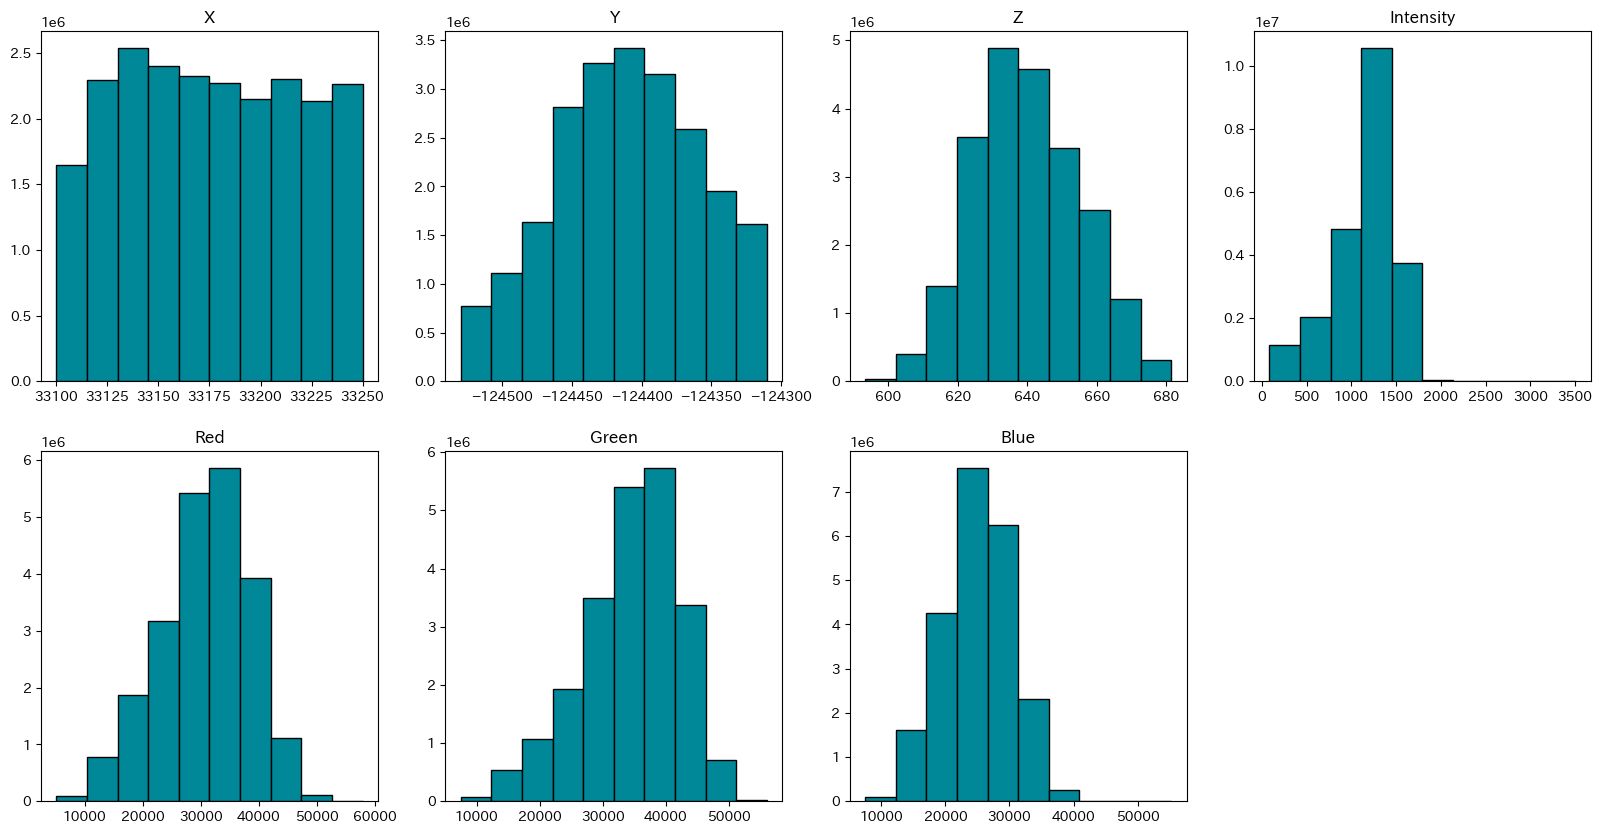

In [ ]:
cols = ['X', 'Y', 'Z', 'Intensity', 'Red', 'Green', 'Blue']

fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(cols):
    ax = fig.add_subplot(2, 4, i+1)
    ds = df[col].to_numpy()
    ax.hist(ds, fc='#008899', ec='black')
    ax.set_title(col)

plt.show()

# おわりに...
----
いかがだったでしょうか。このセッションではLidarデータの記録フォーマットである`.las`を使用して、`pdal`というライブラリを使った`pipeline`処理の流れや、実際のデータを見て見ました。次のセッションではDTM（数値地形モデル）作成などの、点群データのラスター化について解説していきます。
